#Nudging: A Bayesian Bandit model
We have three contents, each with a probability of success (CR), and we must "guess the correct one".

Clearly, we're modeling a problem of multi-armed bandits.

A multi-armed bandit problem is a classic reinforcement learning problem where we have multiple "arms" (options, e.g. nudging contents) to choose from and we want to find the best arm to maximize our total reward. The difficulty comes from the fact that we don't know the underlying distribution of rewards for each arm. So, we need to balance between **exploring** different arms to get more information about their rewards and **exploiting** the arm that has given us the highest reward so far.

In our specific case, we have three Bernoulli bandits - three contents. A Bernoulli bandit returns a reward of 1 with a certain probability p and a reward of 0 with a probability 1-p. The value of p is different and unknown for each bandit.

Here, we're using a Bayesian approach to solve this problem. We start with a uniform prior belief that all values of p from 0 to 1 are equally likely for each bandit. As we start pulling arms and observing rewards, we update our belief about p for each bandit. Specifically, our belief about p is modeled as a Beta distribution with parameters alpha and beta, where alpha is the number of times we received a reward of 1 (successes), and beta is the number of times we received a reward of 0 (failures).

We use Thompson Sampling for arm selection. At each step, we sample a value of p from our current belief (i.e., the Beta distribution) for each arm, and we select the arm with the highest sample. This approach naturally balances exploration and exploitation.

The code will use some **synthetic data** to illustrate the approach.


This code section is about:

- Class Definitions: We define two classes - BernoulliBandit and BayesianBandit. BernoulliBandit represents each Bernoulli bandit and has a pull method to generate a reward. BayesianBandit represents the Bayesian approach with Thompson Sampling and has methods to update the belief (alpha and beta parameters of the Beta distribution) and to sample a value of p for each arm.

- Simulation Function: The simulate function runs the Thompson Sampling algorithm for a specified number of trials. At each trial, it samples a value of p for each arm, selects the arm with the highest sample, pulls this arm to get a reward, and updates the belief based on this reward.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

np.random.seed(33)

class BernoulliBandit:
    def __init__(self, p):
        self.p = p

    def pull(self):
        return int(np.random.random() < self.p)

class BayesianBandit:
    def __init__(self, arm_count):
        self.alpha = np.ones(arm_count)
        self.beta = np.ones(arm_count)
        self.history = np.zeros((arm_count, 0))

    def update(self, arm, reward):
        self.alpha[arm] += reward
        self.beta[arm] += 1 - reward
        self.history = np.hstack((self.history, self.alpha / (self.alpha + self.beta)[:, None]))

    def sample(self):
        return np.random.beta(self.alpha, self.beta)

def simulate(bandits, bandit_algo, n_trials):
    arm_count = len(bandits)
    rewards = np.zeros(n_trials)

    for t in range(n_trials):
        arm_to_pull = np.argmax(bandit_algo.sample())
        reward = bandits[arm_to_pull].pull()
        bandit_algo.update(arm_to_pull, reward)
        rewards[t] = reward

    return rewards

def plot_beliefs_history(bandit_algo):
    for i in range(bandit_algo.history.shape[0]):
        plt.plot(bandit_algo.history[i], label=f"Arm {i+1}")

    plt.title("History of Beliefs about p-values of Each Arm")
    plt.xlabel("Trial")
    plt.ylabel("Estimated p-value")
    plt.legend()
    plt.show()

def plot_beliefs(bandit_algo, true_p_values):
    x = np.linspace(0, 1, 200)
    arm_count = len(bandit_algo.alpha)

    for i in range(arm_count):
        y = beta.pdf(x, bandit_algo.alpha[i], bandit_algo.beta[i])
        plt.plot(x, y, label=f"Arm {i + 1} - True p: {true_p_values[i]:.2f}")

    plt.title("Beliefs about p-values of each arm")
    plt.xlabel("p-value")
    plt.ylabel("Probability density")
    plt.legend()
    plt.show()

This is the main section of the code, where we generate random probabilities for three Bernoulli bandits, create a BayesianBandit instance, run the simulate function for 10,000 trials, and print the total and average rewards.

In [2]:
# Generating random probabilities for the 3 Bernoulli Bandits
p_values = np.random.rand(3)
bandits = [BernoulliBandit(p) for p in p_values]

# Running the Bayesian Bandit algorithm for 10000 trials
bandit_algo = BayesianBandit(len(bandits))
n_trials = 10000
rewards = simulate(bandits, bandit_algo, n_trials)

print(f"Total reward: {rewards.sum()}")
print(f"Average reward per trial: {rewards.sum() / n_trials}")

Total reward: 4345.0
Average reward per trial: 0.4345


Here we plot:
- the **history of estimated probabilities for each arm across the trials** (in the plot, the x-axis represents the trial number, and the y-axis represents the estimated probability; different arms are represented by different lines in the plot);
- the **probability density of the beliefs about the probabilities for each arm** after running the algorithm for the specified number of trials (10000 in this case), i.e. after training.

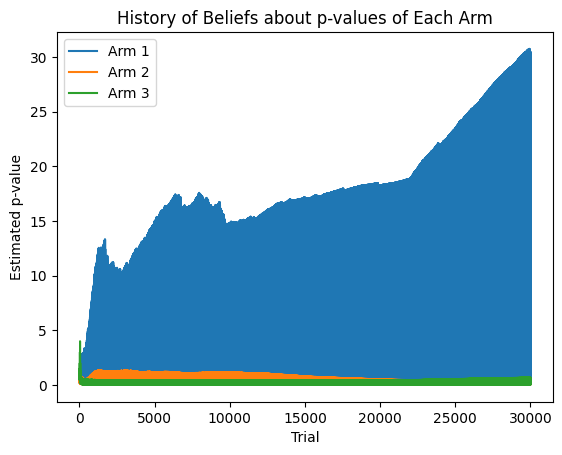

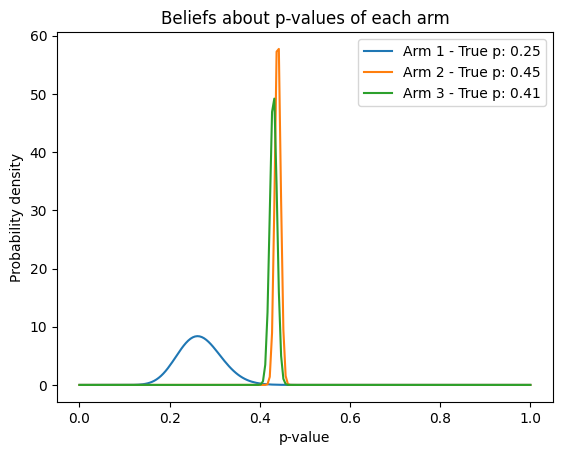

In [ ]:
# Plotting the history of beliefs about p-values of each arm
plot_beliefs_history(bandit_algo)

# Plotting the beliefs about p-values of each arm
plot_beliefs(bandit_algo, p_values)

Let's generate 5 new observations and makes a prediction based on these observations, updating the total reward.

In [ ]:
# Generating new observations
n_new_trials = 5
new_rewards = np.zeros(n_new_trials)
new_observations = [bandit.pull() for bandit in bandits]

# Making a prediction based on the new observations
for t, observation in enumerate(new_observations):
    arm_to_pull = np.argmax(bandit_algo.sample())
    bandit_algo.update(arm_to_pull, observation)
    new_rewards[t] = observation

print(f"New rewards: {new_rewards}")
print(f"Total reward after new observations: {new_rewards.sum() + rewards.sum()}")

New rewards: [0. 0. 1. 0. 0.]
Total reward after new observations: 4346.0
